<a href="https://colab.research.google.com/github/jackalgg/Latency-Prediction-Model/blob/main/Latency_Prediction_Model_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Dependencies

In [2]:
# 1. Install necessary library for Quadkey decoding
!pip install mercantile

from google.colab import drive
import os
import pandas as pd
import numpy as np
import mercantile
import lightgbm as lgb
import gc  # Garbage collector for memory management
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

drive.mount('/content/drive')

# Set plot style
sns.set_style("whitegrid")

print("Libraries installed and imported.")

Mounted at /content/drive
Libraries installed and imported.


## Data Loading and Cleaning

In [3]:
# --- CONFIGURATION ---
# UPDATE THIS PATH to point to the PARQUET file in your Drive
# We are using the 'fixed' tiles (broadband) for this example
FILENAME = '/content/drive/MyDrive/2019-01-01_performance_fixed_tiles.parquet'

# Tuning parameters
RANDOM_SEED = 42
TARGET = 'avg_lat_ms'

# --- HELPER FUNCTIONS ---
def decode_quadkey_batch(qk_series):
    """
    Decodes a series of quadkeys to lat/lon.
    """
    lats = []
    lons = []
    # Ensure series is string type for decoding
    qk_series = qk_series.astype(str)

    for qk in qk_series:
        try:
            tile = mercantile.quadkey_to_tile(qk)
            bounds = mercantile.bounds(tile)
            lats.append((bounds.north + bounds.south) / 2)
            lons.append((bounds.east + bounds.west) / 2)
        except:
            lats.append(np.nan)
            lons.append(np.nan)
    return lats, lons

print("Configuration set for Parquet.")

Configuration set for Parquet.


## Data Loading

In [4]:
import gc

print(f"Loading {FILENAME}...")

# 1. Load Data (Optimized)
# We ONLY load specific columns. We skip 'tile' (geometry) to save massive memory.
columns_to_load = ['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices']

df = pd.read_parquet(FILENAME, columns=columns_to_load)

# 2. Basic Cleaning
df = df.dropna(subset=['avg_lat_ms', 'avg_d_kbps', 'avg_u_kbps', 'quadkey'])

print("Decoding Quadkeys (This may take a moment)...")
# 3. Feature Engineering: Decode Quadkeys
lats, lons = decode_quadkey_batch(df['quadkey'])
df['latitude'] = lats
df['longitude'] = lons

# 4. Target Transformation: Log(1+y)
df['log_avg_lat_ms'] = np.log1p(df['avg_lat_ms'])

# 5. Type Optimization (Float32/Int32)
float_cols = ['avg_d_kbps', 'avg_u_kbps', 'latitude', 'longitude', 'log_avg_lat_ms']
for col in float_cols:
    df[col] = df[col].astype('float32')

int_cols = ['tests', 'devices', 'avg_lat_ms']
for col in int_cols:
    df[col] = df[col].astype('int32')

print(f"Final Data Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")
df.head()

Loading /content/drive/MyDrive/2019-01-01_performance_fixed_tiles.parquet...
Decoding Quadkeys (This may take a moment)...
Final Data Shape: (4877036, 9)
Memory Usage: 0.47 GB


,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,latitude,longitude,log_avg_lat_ms
0,0231113112003202,66216.0,12490.0,13,28,4,38.490143,-90.656433,2.639057
1,1322111021111001,102598.0,37356.0,13,15,4,21.286816,110.354919,2.639057
2,3112203030003110,24686.0,18736.0,18,162,106,-34.924225,138.595276,2.944439
3,0320000130321312,17674.0,13989.0,78,364,4,40.222927,-87.635193,4.369448
4,0320001332313103,441192.0,218955.0,22,14,1,38.918819,-84.740295,3.135494


## Train, Validate, Split

In [5]:
# Define Features (X) and Target (y)
features = ['avg_d_kbps', 'avg_u_kbps', 'tests', 'devices', 'latitude', 'longitude']
X = df[features]
y_log = df['log_avg_lat_ms'] # Use log-transformed target for training

# 1. Split: 80% Train, 20% Temporary
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_log, test_size=0.2, random_state=RANDOM_SEED
)

# 2. Split: Divide Temporary into 50/50 (10% Val, 10% Test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED
)

print(f"Training Set:   {X_train.shape} (80%)")
print(f"Validation Set: {X_val.shape}   (10%)")
print(f"Test Set:       {X_test.shape}   (10%)")

# Clean up full dataframe to save RAM for training
del df
gc.collect()

Training Set:   (3901628, 6) (80%)
Validation Set: (487704, 6)   (10%)
Test Set:       (487704, 6)   (10%)


0

## LightGBM Model Training

In [6]:
print("Initializing LightGBM...")

# Initialize Model
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=5000,       # High cap, relying on early stopping
    learning_rate=0.05,
    num_leaves=31,
    random_state=RANDOM_SEED,
    n_jobs=-1                # Use all CPU cores
)

# Callbacks for Early Stopping
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

print("Starting Training...")
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=callbacks
)

print("Training Complete.")

Initializing LightGBM...
Starting Training...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.416444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1452
[LightGBM] [Info] Number of data points in the train set: 3901628, number of used features: 6
[LightGBM] [Info] Start training from score 3.090800
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.716451	valid_0's l2: 0.513302
[200]	valid_0's rmse: 0.704665	valid_0's l2: 0.496552
[300]	valid_0's rmse: 0.697942	valid_0's l2: 0.487123
[400]	valid_0's rmse: 0.693844	valid_0's l2: 0.481419
[500]	valid_0's rmse: 0.690036	valid_0's l2: 0.47615
[600]	valid_0's rmse: 0.68734	valid_0's l2: 0.472436
[700]	valid_0's rmse: 0.685203	valid_0's l2: 0.469503
[800]	valid_0's rmse: 0.683111	valid_0's l2: 0.466641
[900]	valid_0's rmse: 0.681234	valid_0's l2: 0.46408
[1000]	valid_0's rmse: 0.679445	valid_0's l2: 0.461645
[1100]	valid

## Final Evaluation

--- Final Evaluation on Test Set ---
RMSE: 127.3227 ms
MAE:  25.3009 ms


<Figure size 1000x600 with 0 Axes>

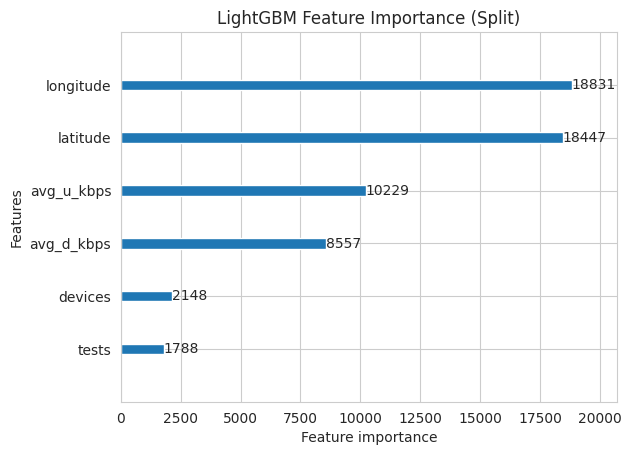

In [ ]:
# Predict on the held-out Test Set
y_pred_log = model.predict(X_test)

# Inverse Transform: Convert log predictions back to milliseconds
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print("--- Final Evaluation on Test Set ---")
print(f"RMSE: {rmse:.4f} ms")
print(f"MAE:  {mae:.4f} ms")

# Visualization: Feature Importance
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=10, importance_type='split')
plt.title("LightGBM Feature Importance (Split)")
plt.show()